# Notebook 03 — Prepare for Modeling

Process **4 datasets × 2 tasks** from the separate `profit/` and `vote/` directories produced by Notebook 02.

| Task | Target | Data Source | Notes |
|---|---|---|---|
| **Classification** | `profitable` (binary) | `data/processed/profit/` | Budget & revenue > 0 |
| **Regression** | `vote_average` (continuous) | `data/processed/vote/` | vote_count > 0 |

| Dataset Variant | Key | Sources |
|---|---|---|
| Metadata Only | `metadata_only` | movies_metadata |
| Meta + Credits | `meta_+_credits` | movies_metadata + credits |
| Meta + Keywords | `meta_+_keywords` | movies_metadata + keywords |
| All Combined | `all_combined` | all three |

**Steps per dataset:** feature selection → one-hot encoding → train/test split → scaling → baseline model.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_squared_error,
                             mean_absolute_error, r2_score, f1_score)
from collections import OrderedDict

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
print("Libraries loaded.")

Libraries loaded.


## 1 · Load All Datasets (Profit & Vote separately)

In [11]:
VARIANTS = ['metadata_only', 'meta_+_credits', 'meta_+_keywords', 'all_combined']
VARIANT_LABELS = {
    'metadata_only':   'Metadata Only',
    'meta_+_credits':  'Meta + Credits',
    'meta_+_keywords': 'Meta + Keywords',
    'all_combined':    'All Combined',
}

PROFIT_DIR = '../data/processed/profit'
VOTE_DIR   = '../data/processed/vote'

# ---- Load Profit datasets (classification) ----
profit_data = {}
print("PROFIT datasets (Classification — target: profitable)")
print("-" * 65)
for v in VARIANTS:
    path = f'{PROFIT_DIR}/movies_processed_{v}.csv'
    df = pd.read_csv(path)
    profit_data[v] = df
    pct = df['profitable'].mean() * 100
    print(f"  {VARIANT_LABELS[v]:20s}  {df.shape[0]:>6,} rows × {df.shape[1]:>2} cols  |  {pct:.1f}% profitable")

# ---- Load Vote datasets (regression) ----
vote_data = {}
print(f"\nVOTE datasets (Regression — target: vote_average)")
print("-" * 65)
for v in VARIANTS:
    path = f'{VOTE_DIR}/movies_processed_{v}.csv'
    df = pd.read_csv(path)
    vote_data[v] = df
    print(f"  {VARIANT_LABELS[v]:20s}  {df.shape[0]:>6,} rows × {df.shape[1]:>2} cols  |  mean={df['vote_average'].mean():.2f}, std={df['vote_average'].std():.2f}")

PROFIT datasets (Classification — target: profitable)
-----------------------------------------------------------------
  Metadata Only          5,359 rows × 17 cols  |  69.9% profitable
  Meta + Credits         5,359 rows × 20 cols  |  69.9% profitable
  Meta + Keywords        5,359 rows × 18 cols  |  69.9% profitable
  All Combined           5,359 rows × 20 cols  |  69.9% profitable

VOTE datasets (Regression — target: vote_average)
-----------------------------------------------------------------
  Metadata Only         40,804 rows × 17 cols  |  mean=6.01, std=1.27
  Meta + Credits        40,804 rows × 19 cols  |  mean=6.01, std=1.27
  Meta + Keywords       40,804 rows × 18 cols  |  mean=6.01, std=1.27
  All Combined          40,804 rows × 20 cols  |  mean=6.01, std=1.27


In [12]:
# Side-by-side comparison
comp_rows = []
for v in VARIANTS:
    comp_rows.append({
        'Dataset': VARIANT_LABELS[v],
        'Profit Rows': len(profit_data[v]),
        'Profit Cols': profit_data[v].shape[1],
        'Profitable %': round(profit_data[v]['profitable'].mean() * 100, 1),
        'Vote Rows': len(vote_data[v]),
        'Vote Cols': vote_data[v].shape[1],
        'Vote Avg Mean': round(vote_data[v]['vote_average'].mean(), 2),
        'Vote Avg Std': round(vote_data[v]['vote_average'].std(), 2),
    })
print(pd.DataFrame(comp_rows).to_string(index=False))

        Dataset  Profit Rows  Profit Cols  Profitable %  Vote Rows  Vote Cols  Vote Avg Mean  Vote Avg Std
  Metadata Only         5359           17          69.9      40804         17           6.01          1.27
 Meta + Credits         5359           20          69.9      40804         19           6.01          1.27
Meta + Keywords         5359           18          69.9      40804         18           6.01          1.27
   All Combined         5359           20          69.9      40804         20           6.01          1.27


## 2 · Correlation Analysis (All Combined — per task)

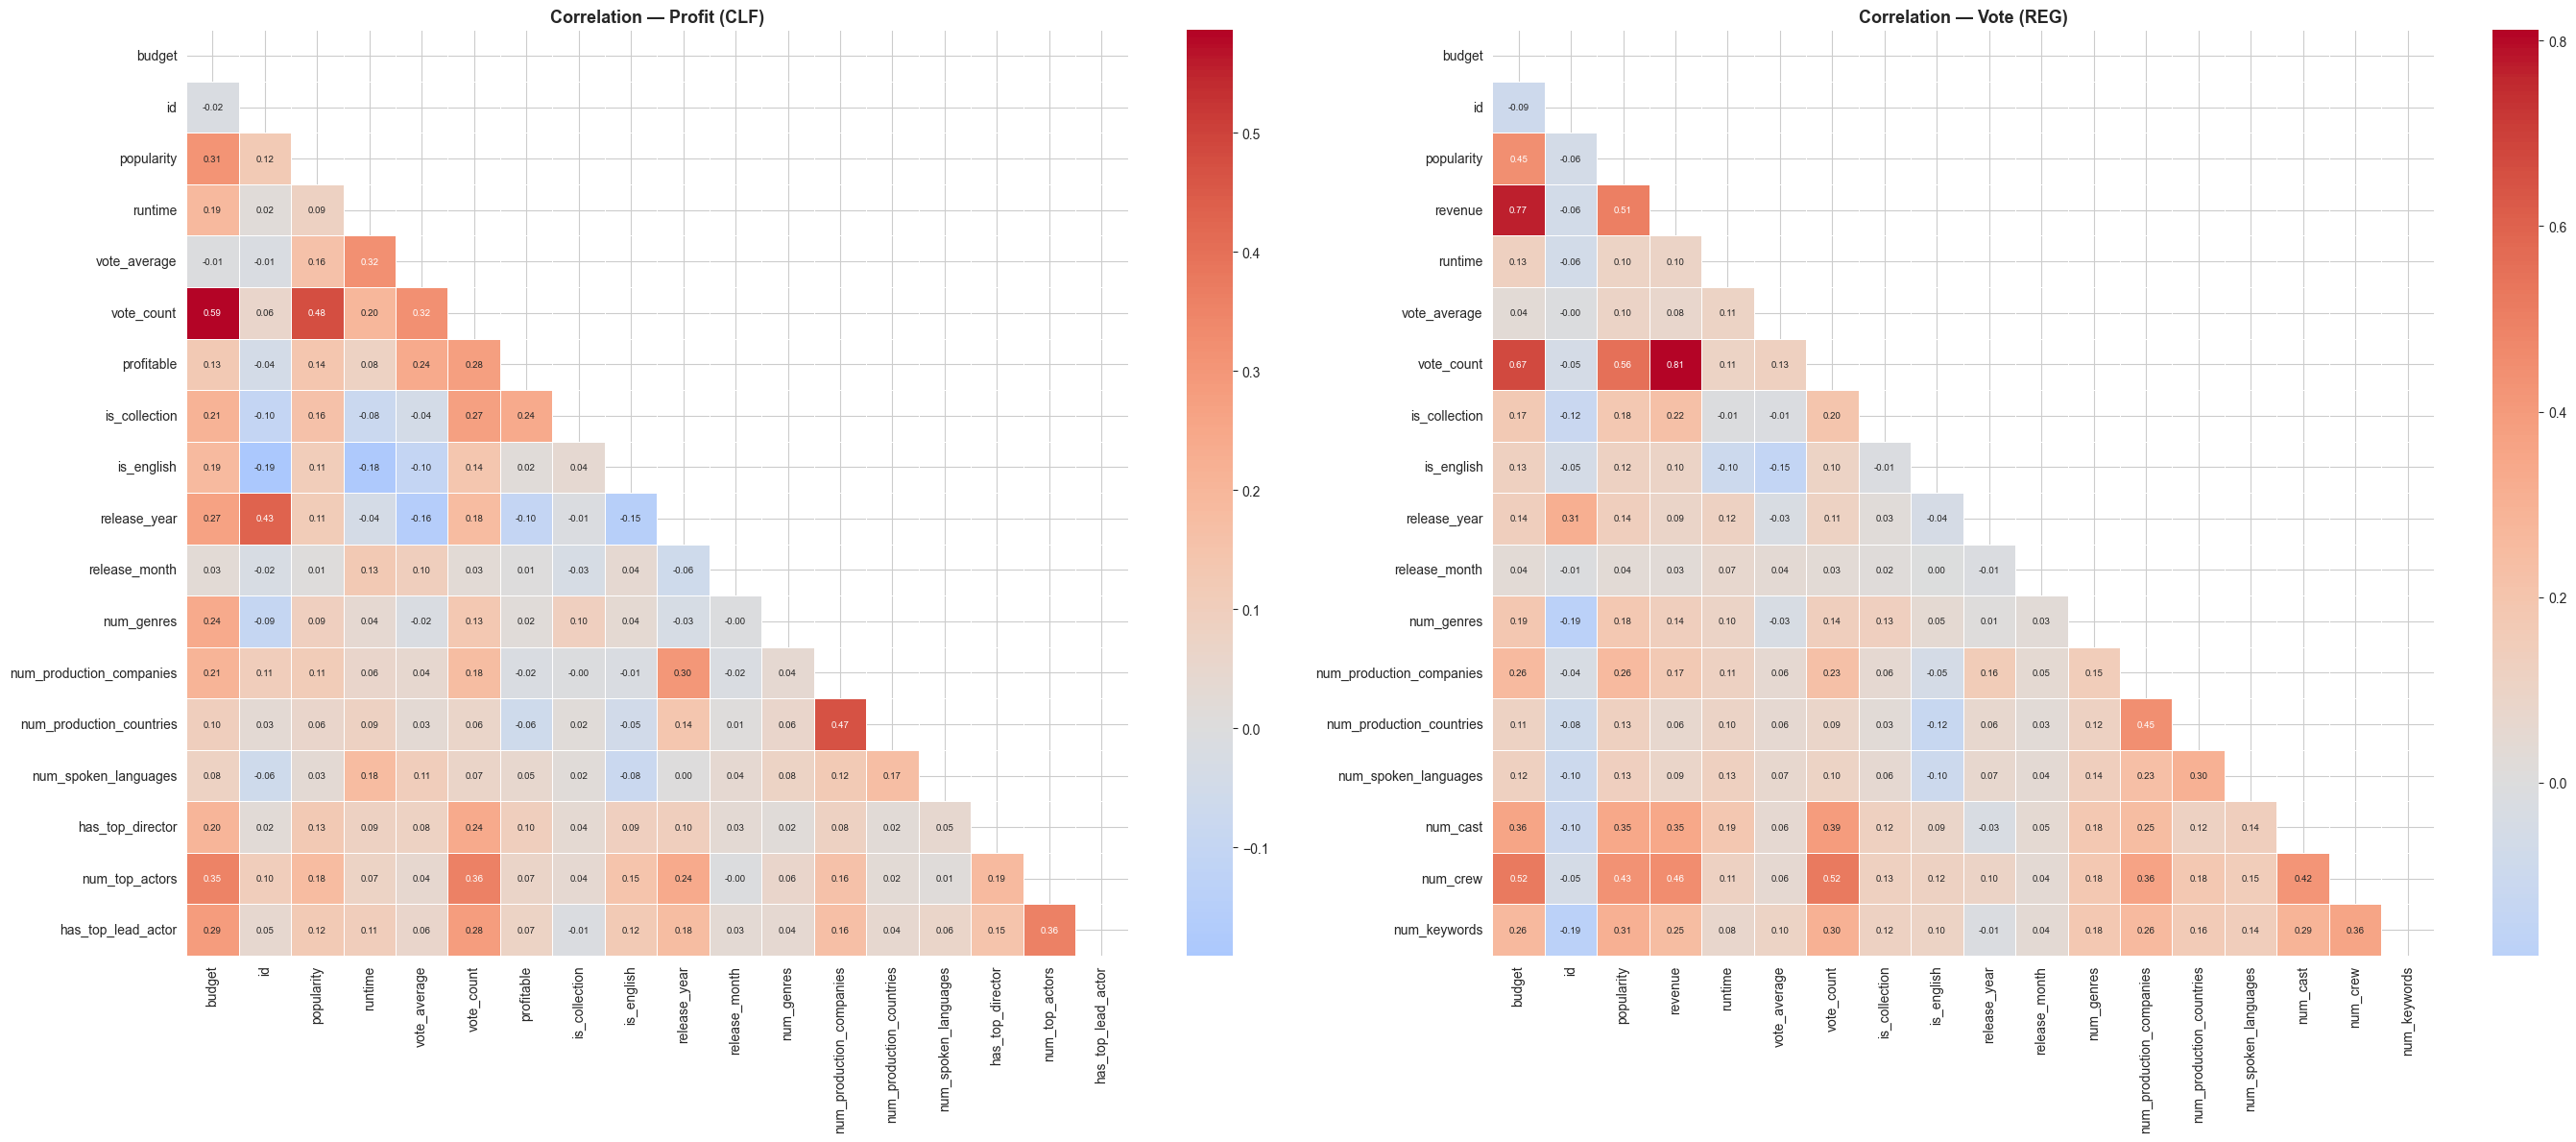

In [13]:
# Correlation heatmaps — one per task using "all_combined" (most features)
fig, axes = plt.subplots(1, 2, figsize=(28, 12))

for ax, (task, df_src, target) in zip(axes, [
        ('Profit (CLF)', profit_data['all_combined'], 'profitable'),
        ('Vote (REG)',   vote_data['all_combined'],   'vote_average')]):
    num = df_src.select_dtypes(include='number')
    corr = num.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, linewidths=0.5, annot_kws={'size': 7}, ax=ax)
    ax.set_title(f'Correlation — {task}', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

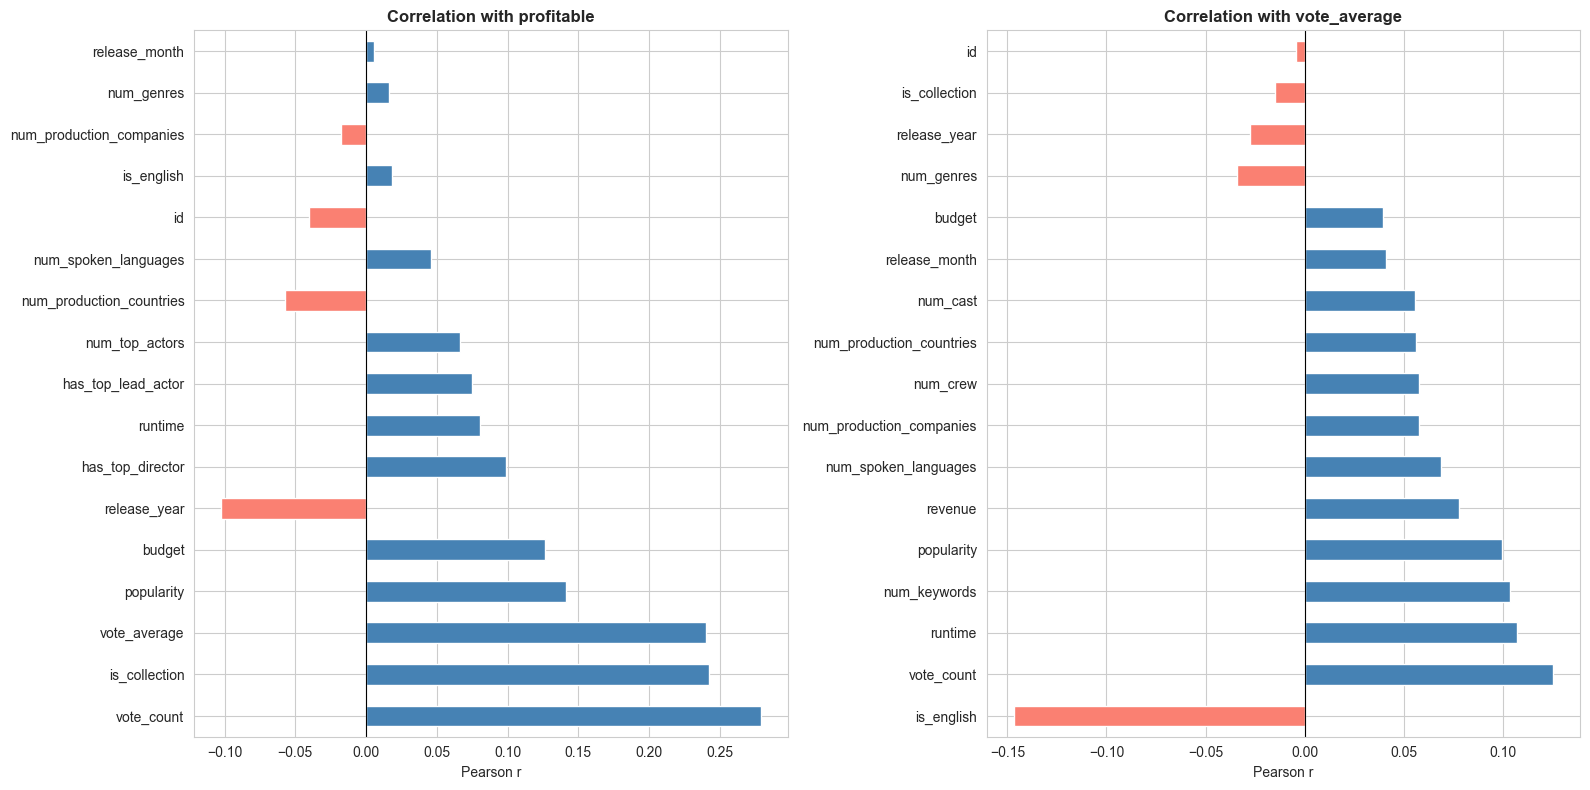

In [14]:
# Correlation with each target
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for ax, (task, df_src, target) in zip(axes, [
        ('profitable',   profit_data['all_combined'], 'profitable'),
        ('vote_average', vote_data['all_combined'],   'vote_average')]):
    num = df_src.select_dtypes(include='number')
    ct = num.corr()[[target]].drop(target)
    ct = ct.reindex(ct[target].abs().sort_values(ascending=False).index)
    ct[target].plot.barh(ax=ax, color=ct[target].apply(
        lambda v: 'steelblue' if v >= 0 else 'salmon'))
    ax.set_title(f'Correlation with {target}', fontsize=12, fontweight='bold')
    ax.axvline(0, color='black', lw=0.8)
    ax.set_xlabel('Pearson r')

plt.tight_layout()
plt.show()

## 3 · Process Profit Datasets — Classification

For each of the 4 profit dataset variants:
1. One-hot encode `primary_genre`, drop `id` and `title`
2. Target = `profitable` (already binary)
3. Stratified 80/20 split → StandardScaler → Logistic Regression baseline
4. Save splits to `data/processed/profit/{variant}/`

In [15]:
clf_results = OrderedDict()

for v in VARIANTS:
    label = VARIANT_LABELS[v]
    print(f"\n{'='*70}")
    print(f"  PROFIT — {label}  ({v})")
    print(f"{'='*70}")

    df = profit_data[v].copy()
    df_model = pd.get_dummies(df, columns=['primary_genre'], drop_first=True, dtype=int)
    df_model.drop(columns=['id', 'title'], inplace=True, errors='ignore')
    print(f"  Shape after encoding: {df_model.shape}")

    # Target & features
    X = df_model.drop(columns=['profitable'])
    y = df_model['profitable']

    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale
    scaler = StandardScaler()
    X_train_sc = pd.DataFrame(scaler.fit_transform(X_train),
                              columns=X_train.columns, index=X_train.index)
    X_test_sc = pd.DataFrame(scaler.transform(X_test),
                             columns=X_test.columns, index=X_test.index)

    # Baseline — Logistic Regression
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train_sc, y_train)
    y_pred = lr.predict(X_test_sc)
    acc  = accuracy_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    print(f"  Accuracy: {acc:.4f}   F1: {f1:.4f}")
    print(f"  Features: {X.shape[1]}   Train: {len(X_train)}   Test: {len(X_test)}")

    # Save splits
    out_dir = f'{PROFIT_DIR}/{v}'
    os.makedirs(out_dir, exist_ok=True)
    X_train_sc.to_csv(f'{out_dir}/X_train_clf.csv', index=False)
    X_test_sc.to_csv(f'{out_dir}/X_test_clf.csv', index=False)
    y_train.to_csv(f'{out_dir}/y_train_clf.csv', index=False)
    y_test.to_csv(f'{out_dir}/y_test_clf.csv', index=False)
    pd.Series(X_train.columns.tolist()).to_csv(
        f'{out_dir}/features_clf.csv', index=False, header=['feature'])

    # Save scaler
    os.makedirs('../models', exist_ok=True)
    joblib.dump(scaler, f'../models/scaler_clf_profit_{v}.pkl')

    clf_results[v] = {
        'label': label, 'n_samples': len(df),
        'n_features': X.shape[1], 'accuracy': acc, 'f1': f1,
        'train_size': len(X_train), 'test_size': len(X_test),
    }
    print(f"  ✓ Saved to {out_dir}/")


  PROFIT — Metadata Only  (metadata_only)
  Shape after encoding: (5359, 34)
  Accuracy: 0.7826   F1: 0.8511
  Features: 33   Train: 4287   Test: 1072
  ✓ Saved to ../data/processed/profit/metadata_only/

  PROFIT — Meta + Credits  (meta_+_credits)
  Shape after encoding: (5359, 37)
  Accuracy: 0.7780   F1: 0.8474
  Features: 36   Train: 4287   Test: 1072
  ✓ Saved to ../data/processed/profit/meta_+_credits/

  PROFIT — Meta + Keywords  (meta_+_keywords)
  Shape after encoding: (5359, 35)
  Accuracy: 0.7799   F1: 0.8499
  Features: 34   Train: 4287   Test: 1072
  ✓ Saved to ../data/processed/profit/meta_+_keywords/

  PROFIT — All Combined  (all_combined)
  Shape after encoding: (5359, 37)
  Accuracy: 0.7780   F1: 0.8474
  Features: 36   Train: 4287   Test: 1072
  ✓ Saved to ../data/processed/profit/all_combined/


## 4 · Process Vote Datasets — Regression

For each of the 4 vote dataset variants:
1. One-hot encode `primary_genre`, drop `id` and `title`
2. Target = `vote_average`
3. 80/20 split → StandardScaler → Linear Regression baseline
4. Save splits to `data/processed/vote/{variant}/`

In [16]:
reg_results = OrderedDict()

for v in VARIANTS:
    label = VARIANT_LABELS[v]
    print(f"\n{'='*70}")
    print(f"  VOTE — {label}  ({v})")
    print(f"{'='*70}")

    df = vote_data[v].copy()
    df_model = pd.get_dummies(df, columns=['primary_genre'], drop_first=True, dtype=int)
    df_model.drop(columns=['id', 'title'], inplace=True, errors='ignore')
    print(f"  Shape after encoding: {df_model.shape}")

    # Target & features
    X = df_model.drop(columns=['vote_average'])
    y = df_model['vote_average']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Scale
    scaler = StandardScaler()
    X_train_sc = pd.DataFrame(scaler.fit_transform(X_train),
                              columns=X_train.columns, index=X_train.index)
    X_test_sc = pd.DataFrame(scaler.transform(X_test),
                             columns=X_test.columns, index=X_test.index)

    # Baseline — Linear Regression
    linreg = LinearRegression()
    linreg.fit(X_train_sc, y_train)
    y_pred = linreg.predict(X_test_sc)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    print(f"  RMSE: {rmse:.4f}   MAE: {mae:.4f}   R²: {r2:.4f}")
    print(f"  Features: {X.shape[1]}   Train: {len(X_train)}   Test: {len(X_test)}")

    # Save splits
    out_dir = f'{VOTE_DIR}/{v}'
    os.makedirs(out_dir, exist_ok=True)
    X_train_sc.to_csv(f'{out_dir}/X_train_reg.csv', index=False)
    X_test_sc.to_csv(f'{out_dir}/X_test_reg.csv', index=False)
    y_train.to_csv(f'{out_dir}/y_train_reg.csv', index=False)
    y_test.to_csv(f'{out_dir}/y_test_reg.csv', index=False)
    pd.Series(X_train.columns.tolist()).to_csv(
        f'{out_dir}/features_reg.csv', index=False, header=['feature'])

    # Save scaler
    joblib.dump(scaler, f'../models/scaler_reg_vote_{v}.pkl')

    reg_results[v] = {
        'label': label, 'n_samples': len(df),
        'n_features': X.shape[1], 'rmse': rmse, 'mae': mae, 'r2': r2,
        'train_size': len(X_train), 'test_size': len(X_test),
    }
    print(f"  ✓ Saved to {out_dir}/")


  VOTE — Metadata Only  (metadata_only)
  Shape after encoding: (40804, 34)
  RMSE: 1.1928   MAE: 0.8827   R²: 0.1415
  Features: 33   Train: 32643   Test: 8161
  ✓ Saved to ../data/processed/vote/metadata_only/

  VOTE — Meta + Credits  (meta_+_credits)
  Shape after encoding: (40804, 36)
  RMSE: 1.1928   MAE: 0.8823   R²: 0.1415
  Features: 35   Train: 32643   Test: 8161
  ✓ Saved to ../data/processed/vote/meta_+_credits/

  VOTE — Meta + Keywords  (meta_+_keywords)
  Shape after encoding: (40804, 35)
  RMSE: 1.1885   MAE: 0.8764   R²: 0.1478
  Features: 34   Train: 32643   Test: 8161
  ✓ Saved to ../data/processed/vote/meta_+_keywords/

  VOTE — All Combined  (all_combined)
  Shape after encoding: (40804, 37)
  RMSE: 1.1886   MAE: 0.8763   R²: 0.1476
  Features: 36   Train: 32643   Test: 8161
  ✓ Saved to ../data/processed/vote/all_combined/


In [17]:
## 5 · Baseline Comparison Across Datasets

CLASSIFICATION BASELINES (Profit)
                           label n_samples n_features  accuracy        f1
Variant                                                                  
metadata_only      Metadata Only      5359         33  0.782649  0.851118
meta_+_credits    Meta + Credits      5359         36  0.777985  0.847436
meta_+_keywords  Meta + Keywords      5359         34  0.779851  0.849873
all_combined        All Combined      5359         36  0.777985  0.847436


REGRESSION BASELINES (Vote)
                           label n_samples n_features      rmse       mae        r2
Variant                                                                            
metadata_only      Metadata Only     40804         33  1.192827  0.882674  0.141499
meta_+_credits    Meta + Credits     40804         35  1.192794  0.882291  0.141545
meta_+_keywords  Meta + Keywords     40804         34  1.188454  0.876397  0.147782
all_combined        All Combined     40804         36  1.188577   0.8762

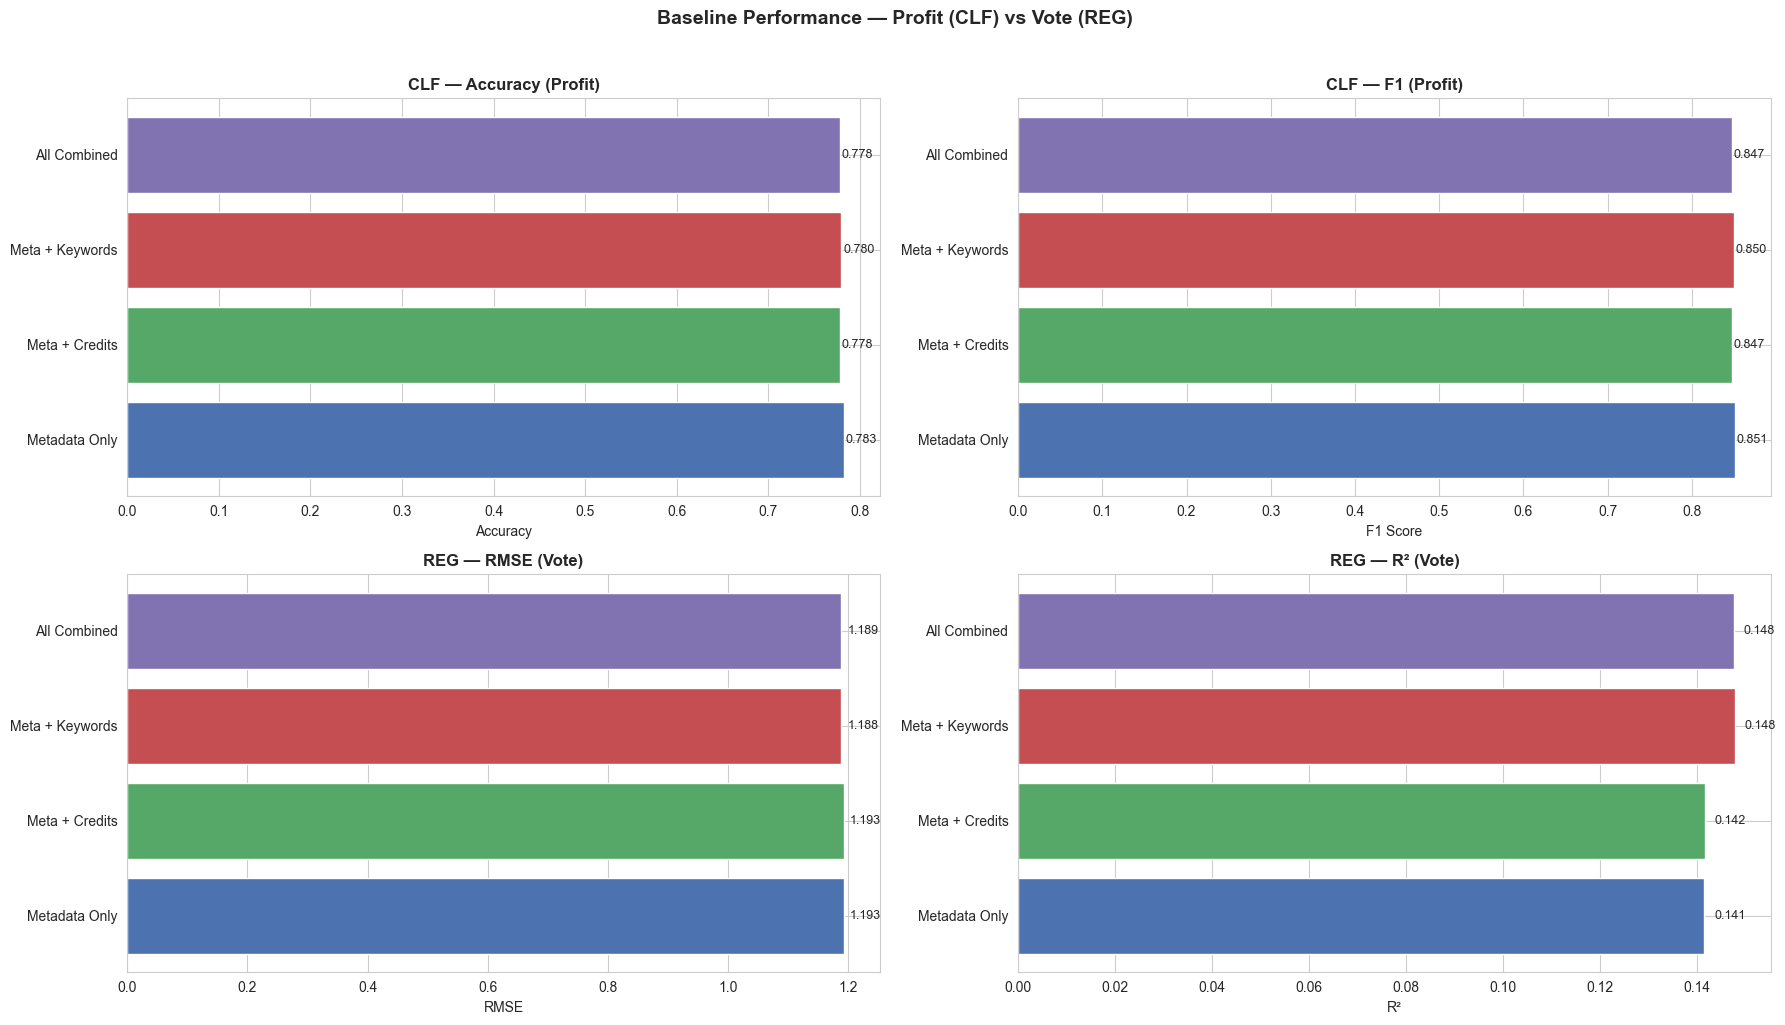

In [18]:
# ---- Classification Summary ----
clf_df = pd.DataFrame(clf_results).T
clf_df.index.name = 'Variant'
print("CLASSIFICATION BASELINES (Profit)")
print("=" * 80)
print(clf_df[['label', 'n_samples', 'n_features', 'accuracy', 'f1']].to_string())

print(f"\n\nREGRESSION BASELINES (Vote)")
print("=" * 80)
reg_df = pd.DataFrame(reg_results).T
reg_df.index.name = 'Variant'
print(reg_df[['label', 'n_samples', 'n_features', 'rmse', 'mae', 'r2']].to_string())

# ---- Visualisation ----
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
labels = [VARIANT_LABELS[v] for v in VARIANTS]
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']

# CLF — Accuracy
vals = [clf_results[v]['accuracy'] for v in VARIANTS]
axes[0, 0].barh(labels, vals, color=colors)
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('CLF — Accuracy (Profit)', fontweight='bold')
for i, val in enumerate(vals):
    axes[0, 0].text(val + 0.002, i, f'{val:.3f}', va='center', fontsize=9)

# CLF — F1
vals = [clf_results[v]['f1'] for v in VARIANTS]
axes[0, 1].barh(labels, vals, color=colors)
axes[0, 1].set_xlabel('F1 Score')
axes[0, 1].set_title('CLF — F1 (Profit)', fontweight='bold')
for i, val in enumerate(vals):
    axes[0, 1].text(val + 0.002, i, f'{val:.3f}', va='center', fontsize=9)

# REG — RMSE
vals = [reg_results[v]['rmse'] for v in VARIANTS]
axes[1, 0].barh(labels, vals, color=colors)
axes[1, 0].set_xlabel('RMSE')
axes[1, 0].set_title('REG — RMSE (Vote)', fontweight='bold')
for i, val in enumerate(vals):
    axes[1, 0].text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=9)

# REG — R²
vals = [reg_results[v]['r2'] for v in VARIANTS]
axes[1, 1].barh(labels, vals, color=colors)
axes[1, 1].set_xlabel('R²')
axes[1, 1].set_title('REG — R² (Vote)', fontweight='bold')
for i, val in enumerate(vals):
    axes[1, 1].text(val + 0.002, i, f'{val:.3f}', va='center', fontsize=9)

plt.suptitle('Baseline Performance — Profit (CLF) vs Vote (REG)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [19]:
# Summary of saved artifacts
print("SAVED ARTIFACTS")
print("=" * 70)

print("\n--- PROFIT (Classification) ---")
for v in VARIANTS:
    out = f'{PROFIT_DIR}/{v}'
    print(f"\n  {VARIANT_LABELS[v]} ({v}):")
    print(f"    Splits  : {out}/X_train_clf.csv, X_test_clf.csv, y_train_clf.csv, y_test_clf.csv")
    print(f"    Features: {out}/features_clf.csv")
    print(f"    Scaler  : ../models/scaler_clf_profit_{v}.pkl")

print("\n--- VOTE (Regression) ---")
for v in VARIANTS:
    out = f'{VOTE_DIR}/{v}'
    print(f"\n  {VARIANT_LABELS[v]} ({v}):")
    print(f"    Splits  : {out}/X_train_reg.csv, X_test_reg.csv, y_train_reg.csv, y_test_reg.csv")
    print(f"    Features: {out}/features_reg.csv")
    print(f"    Scaler  : ../models/scaler_reg_vote_{v}.pkl")

SAVED ARTIFACTS

--- PROFIT (Classification) ---

  Metadata Only (metadata_only):
    Splits  : ../data/processed/profit/metadata_only/X_train_clf.csv, X_test_clf.csv, y_train_clf.csv, y_test_clf.csv
    Features: ../data/processed/profit/metadata_only/features_clf.csv
    Scaler  : ../models/scaler_clf_profit_metadata_only.pkl

  Meta + Credits (meta_+_credits):
    Splits  : ../data/processed/profit/meta_+_credits/X_train_clf.csv, X_test_clf.csv, y_train_clf.csv, y_test_clf.csv
    Features: ../data/processed/profit/meta_+_credits/features_clf.csv
    Scaler  : ../models/scaler_clf_profit_meta_+_credits.pkl

  Meta + Keywords (meta_+_keywords):
    Splits  : ../data/processed/profit/meta_+_keywords/X_train_clf.csv, X_test_clf.csv, y_train_clf.csv, y_test_clf.csv
    Features: ../data/processed/profit/meta_+_keywords/features_clf.csv
    Scaler  : ../models/scaler_clf_profit_meta_+_keywords.pkl

  All Combined (all_combined):
    Splits  : ../data/processed/profit/all_combined/X_trai

## Summary

### Two Independent Pipelines

| Step | Profit (Classification) | Vote (Regression) |
|---|---|---|
| **Data source** | `data/processed/profit/` | `data/processed/vote/` |
| **Target** | `profitable` (binary) | `vote_average` (continuous) |
| **Dropped** | `id`, `title` | `id`, `title` |
| **Encoding** | One-hot `primary_genre` | One-hot `primary_genre` |
| **Split** | 80/20 stratified | 80/20 |
| **Scaling** | StandardScaler (train-fit) | StandardScaler (train-fit) |
| **Baseline** | Logistic Regression | Linear Regression |

### Saved Artifacts (per variant × per task)
- **Profit:** `profit/{variant}/X_train_clf.csv`, `…_test_clf.csv`, `y_train_clf.csv`, `y_test_clf.csv`, `features_clf.csv`
- **Vote:** `vote/{variant}/X_train_reg.csv`, `…_test_reg.csv`, `y_train_reg.csv`, `y_test_reg.csv`, `features_reg.csv`
- **Scalers:** `models/scaler_clf_profit_{variant}.pkl`, `models/scaler_reg_vote_{variant}.pkl`

### Next Steps
1. **Notebook 04** — Train & compare models on all 4×2 dataset/task combinations
2. Hyperparameter tuning per variant
3. Cross-variant performance comparison